In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from utils_data_structures import col_prefixes



In [9]:
grouped_df = pd.read_csv('sorare_data/large_grouped_sorare_data.csv')



print(grouped_df['So_5_Scores_9'].isna().sum())
grouped_df.shape

0


(15554, 318)

In [10]:


# get dummies for current club
# processed_df = pd.get_dummies(grouped_df, columns=['Current_Club'])
processed_df = grouped_df.drop(columns=['Current_Club'])
le = LabelEncoder()
processed_df['Position_Encoded'] = le.fit_transform(processed_df['Position'])

columns_to_drop = ['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position']
processed_df = processed_df.drop(columns=columns_to_drop)

processed_df.fillna(0.0)

# pd.set_option('display.max_columns', None)
processed_df.dtypes.value_counts()

float64    308
int64        4
int32        1
Name: count, dtype: int64

In [11]:
# Check for inf and -inf values in each column
inf_columns = processed_df.apply(lambda x: np.isinf(x).sum())
print(inf_columns[inf_columns > 0])

# Check for excessively large values in each column
large_value_columns = processed_df.apply(lambda x: (x > 3.4e+38).sum())
print(large_value_columns[large_value_columns > 0])

Series([], dtype: int64)
Series([], dtype: int64)


In [12]:
# Create X and y and split into training and testing sets
target_column = 'So_5_Scores_9'
columns_to_drop = [f'{col}_9' for col in col_prefixes]

old_columns_drop = []
for i in range(0, 5):
    for col in col_prefixes:
        old_columns_drop.append(f'{col}_{i}')
columns_to_drop.extend(old_columns_drop)

print(col_prefixes)


X = processed_df.drop(columns=columns_to_drop)
y = processed_df[target_column]


['So_5_Scores', 'accuratePass', 'assistPenaltyWon', 'bigChanceCreated', 'cleanSheet', 'cleanSheet60', 'crossAccuracy', 'duelWon', 'effectiveClearance', 'errorLeadToGoal', 'fouls', 'gameStarted', 'goalAssist', 'goals', 'interceptionWon', 'lastManTackle', 'minsPlayed', 'ownGoals', 'passAccuracy', 'penaltiesSaved', 'penaltyConceded', 'penaltyKickMissed', 'penaltySave', 'redCard', 'saves', 'shotAccuracy', 'totalClearance', 'totalPass', 'wonTackle', 'yellowCard']


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y.isna().sum())

0


In [14]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [15]:
# Make predictions
y_pred = rf.predict(X_test)


In [16]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

Mean Squared Error: 262.98125609314735
RMSE: 16.216696830524622


In [17]:
best = {'i': 0, 'j': 0, 'rmse': float('inf')}
perf_dict = {}
for i in range(250, 1000, 250):
    for j in range(1,101, 50):
        rf = RandomForestRegressor(n_estimators=i, max_depth=j, random_state=42)

        # Train the model
        rf.fit(X_train, y_train)

        # Make predictions
        y_pred = rf.predict(X_test)
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        print(f'Mean Squared Error: {mse}')

        rmse = np.sqrt(mse)
        print(f'RMSE: {rmse}')
        if i not in perf_dict:
            perf_dict[i] = {}  # Initialize for each 'i'
        perf_dict[i][j] = {'rmse': rmse}  # Store RMSE for each 'j'
        if rmse < best['rmse']:
            print(f'New Best: {rmse}')
            best['i'] = i
            best['j'] = j
            best['rmse'] = rmse
        print(f'i: {i} | j: {j}')
print(f"Best Parameters: n_estimators={best['i']}, max_depth={best['j']}, RMSE={best['rmse']}")
        

Mean Squared Error: 293.4747344429205
RMSE: 17.131104297240167
New Best: 17.131104297240167
i: 250 | j: 1
Mean Squared Error: 260.3985463258938
RMSE: 16.136869161206388
New Best: 16.136869161206388
i: 250 | j: 51
Mean Squared Error: 293.32041107137354
RMSE: 17.126599518625216
i: 500 | j: 1
Mean Squared Error: 258.9935552938199
RMSE: 16.093276710906945
New Best: 16.093276710906945
i: 500 | j: 51
Mean Squared Error: 293.94354738887574
RMSE: 17.144781928880743
i: 750 | j: 1
Mean Squared Error: 258.40217364037943
RMSE: 16.07489264786485
New Best: 16.07489264786485
i: 750 | j: 51
Best Parameters: n_estimators=750, max_depth=51, RMSE=16.07489264786485


In [18]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 800, 1000],   # Number of trees
    'max_depth': [10, 20, None],       # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]      # Minimum samples per leaf node
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3,  # 3-fold cross-validation
                           scoring='neg_mean_squared_error',  # Use MSE for scoring
                           verbose=2,  # Print progress
                           n_jobs=-1)  # Use all CPU cores

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

# Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 1000}
# Best RMSE: 19.945626684725617

Fitting 3 folds for each of 189 candidates, totalling 567 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 400}
Best RMSE: 16.609100748309164


In [19]:
param_distributions = {
    'n_estimators': np.arange(100, 500, 50),   # Randomly sample from 100 to 500 with a step of 50
    'max_depth': [10, 20, 30, None],           # Random depth values
    'min_samples_split': [2, 5, 10],           # Split criteria
    'min_samples_leaf': [1, 2, 4]              # Leaf node criteria
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, 
                                   param_distributions=param_distributions, 
                                   n_iter=50,  # Number of random combinations to try
                                   cv=3,  # 3-fold cross-validation
                                   scoring='neg_mean_squared_error',  # Use MSE for scoring
                                   verbose=2,  # Print progress
                                   random_state=42,  # For reproducibility
                                   n_jobs=-1)  # Use all CPU cores

# Fit the model with random search
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")
# Best Parameters: {'n_estimators': np.int64(900), 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20}
# Best RMSE: 19.934293139076406

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}
Best RMSE: 16.614807008653035


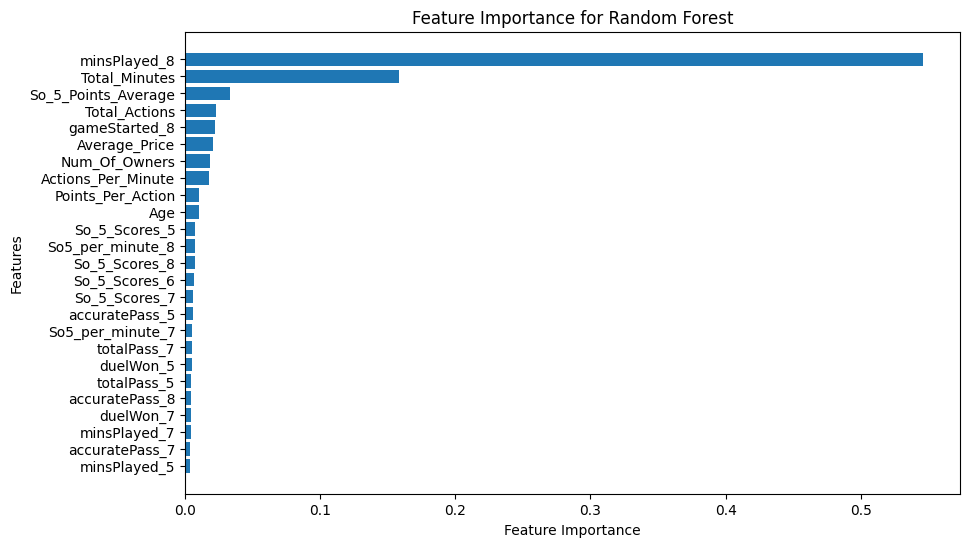

In [20]:
import matplotlib.pyplot as plt

# Assuming you've already trained a RandomForest model
rf_model = RandomForestRegressor(max_depth= 10, min_samples_leaf= 4,min_samples_split= 10, n_estimators= 250, random_state=42)
rf_model.fit(X_train, y_train)


# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

top_n = 25  # Number of top features to show
top_features = feature_importance_df.nlargest(top_n, 'Importance')

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Random Forest')
plt.gca().invert_yaxis()
plt.show()